# Before start...
*Install packages*

In [ ]:
!pip install transformers>=4.11.3 sentencepiece
!pip install simpletransformers>=0.61.10

In [ ]:
!pip install numpy requests nlpaug
!pip install nltk>=3.4.5
!pip install gensim>=4.1.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 410 kB 5.1 MB/s 


# Train dataset

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
reply = pd.read_csv('charliehebdo-target-reply-600.csv', encoding = 'utf-8', header = 0)
src = pd.read_csv('charliehebdo-target-src.csv', encoding = 'utf-8', header = 0)

In [ ]:
a = reply[['cleaned_reply_tw','true_label']]
a.columns = ['text','labels']

In [ ]:
b = src[['cleaned_src_tw','true_label']]
b.columns = ['text','labels']

In [ ]:
df = pd.concat([a,b])

In [ ]:
df

,text,labels
0,morons tarnish,0.0
1,pray hostages,0.0
2,waar arabische bron,NaN
3,NaN,0.0
4,NaN,0.0
...,...,...
442,afp several hostages free jewish supermarket p...,0.0
443,several hostages free jewish supermarket paris...,0.0
444,report several hostages apparently free paris ...,0.0
445,several hostages free jewish supermarket paris...,0.0


In [ ]:
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)

In [ ]:
df.labels.value_counts()

0.0    808
1.0    150
Name: labels, dtype: int64

## Train & Test Sets

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_data, test_data = train_test_split(df,test_size = 0.1,stratify= df.labels,random_state = 8574)

In [ ]:
print("Train dataset:\n",train_data.labels.value_counts())
print("Test dataset:\n",test_data.labels.value_counts())

Train dataset:
 0.0    727
1.0    135
Name: labels, dtype: int64
Test dataset:
 0.0    81
1.0    15
Name: labels, dtype: int64


In [ ]:
train_data.reset_index(drop=True,inplace=True)
test_data.reset_index(drop=True,inplace=True)

## Handle imbalanced data - Initialize augmenters

In [ ]:
# from nlpaug.util.file.download import DownloadUtil
# DownloadUtil.download_word2vec(dest_dir='.') # Download word2vec model

In [ ]:
import nlpaug
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas

### Replace a few words with their synonyms/antonyms

#### Synonyms

In [ ]:
#initialize a synonymaug object
aug_syn = naw.SynonymAug(aug_src='wordnet',aug_min=1)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# example
print(" - original text: {}".format(train_data.text[0]))
print(" - augmented text:\n{}".format(aug_syn.augment(train_data.text[0],n=3)))

 - original text: amen


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


 - augmented text:
['amon', 'amon', 'amon']


In [ ]:
# Augmentation by syn words
'''
def aug_synonym(df0):
  #create an empty list to store the generated tweets
  aug_text_list = list()
  #extract sequences in the minority class (where 'labels' ==1) in the dataset(df0)
  minority = df0.loc[df0.labels==1].text.astype('str')
  #generate 3 augmented sentences for each tweet. save them into the aug_text_list
  for i in minority:
    temp = aug_syn.augment(i,n=3)
    aug_text_list.extend(temp)
  return aug_text_list
'''

#### Antonyms

In [ ]:
aug_ant = naw.AntonymAug(aug_min = 1)

In [ ]:
# example
print(" - original text: {}".format(train_data.text[0]))
print(" - augmented text:\n{}".format(aug_ant.augment(train_data.text[0],n=3)))

 - original text: amen
 - augmented text:
['amen', 'amen', 'amen']


In [ ]:
# Augmentation by antonym words
'''
def aug_antonym(df0):
  #create an empty list to store the generated tweets
  aug_text_list = list()
  #extract sequences in the minority class (where 'labels' ==1) in the dataset(df0)
  minority = df0.loc[df0.labels==1].text.astype('str')
  #generate 3 augmented sentences for each tweet. save them into the aug_text_list
  for i in minority:
    temp = aug_ant.augment(i,n=3)
    aug_text_list.extend(temp)
  return aug_text_list
'''

"\ndef aug_antonym(df0):\n  #create an empty list to store the generated tweets\n  aug_text_list = list()\n  #extract sequences in the minority class (where 'labels' ==1) in the dataset(df0)\n  minority = df0.loc[df0.labels==1].text.astype('str')\n  #generate 3 augmented sentences for each tweet. save them into the aug_text_list\n  for i in minority:\n    temp = aug_ant.augment(i,n=3)\n    aug_text_list.extend(temp)\n  return aug_text_list\n"

### Replace a few words with words that have similar word embeddings
based on cosine similarity, like word2vec or GloVe

In [ ]:
import nlpaug.model.word_embs as nmw
word2vec = nmw.Word2vec()
aug_embedding = naw.WordEmbsAug(
    model_type='word2vec',model = word2vec, action="substitute")

In [ ]:
# example
print(" - original text: {}".format(train_data.text[0]))
print(" - augmented text:\n{}".format(aug_embedding.augment(train_data.text[0],n=3)))

 - original text: amen
 - augmented text:
['amen', 'amen', 'amen']


In [ ]:
# Augmentation by substituting words with similiar word2vec 
'''
def aug_word2vec(df0):
  #create an empty list to store the generated tweets
  aug_text_list = list()
  #extract sequences in the minority class (where 'labels' ==1) in the dataset(df0)
  minority = df0.loc[df0.labels==1].text.astype('str')
  #generate 3 augmented sentences for each tweet. save them into the aug_text_list
  for i in minority:
    temp = aug_embedding.augment(i,n=3)
    aug_text_list.extend(temp)
  return aug_text_list
'''

### Replace words based on the context using transformer models 
(BERT)

#### 1. Insert words

In [ ]:
aug_transformers_insert = naw.ContextualWordEmbsAug(
    model_path='bert-base-uncased', action="insert")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# example
print(" - original text: {}".format(train_data.text[0]))
print(" - augmented text:\n{}".format(aug_transformers_insert.augment(train_data.text[0],n=3)))

 - original text: amen
 - augmented text:
['so amen', 'and amen', '30 amen']


In [ ]:
# Augmentation by insert words from transformer model 
'''
def aug_bert_insert(df0):
  #create an empty list to store the generated tweets
  aug_text_list = list()
  #extract sequences in the minority class (where 'labels' ==1) in the dataset(df0)
  minority = df0.loc[df0.labels==1].text.astype('str')
  #generate 3 augmented sentences for each tweet. save them into the aug_text_list
  for i in minority:
    temp = aug_transformers_insert.augment(i,n=3)
    aug_text_list.extend(temp)
  return aug_text_list
'''

#### 2. Substitute words


In [ ]:
aug_transformers_sub = naw.ContextualWordEmbsAug(
    model_path='bert-base-uncased', action="substitute")

In [ ]:
# example
print(" - original text: {}".format(train_data.text[0]))
print(" - augmented text:\n{}".format(aug_transformers_sub.augment(train_data.text[0],n=3)))

 - original text: amen
 - augmented text:
['i', 'p', '[UNK]']


In [ ]:
# Augmentation by substitue words from transformer model 
'''
def aug_bert_sub(df0):
  #create an empty list to store the generated tweets
  aug_text_list = list()
  #extract sequences in the minority class (where 'labels' ==1) in the dataset(df0)
  minority = df0.loc[df0.labels==1].text.astype('str')
  #generate 3 augmented sentences for each tweet. save them into the aug_text_list
  for i in minority:
    temp = aug_transformers_sub.augment(i,n=3)
    aug_text_list.extend(temp)
  return aug_text_list
'''

"\ndef aug_bert_sub(df0):\n  #create an empty list to store the generated tweets\n  aug_text_list = list()\n  #extract sequences in the minority class (where 'labels' ==1) in the dataset(df0)\n  minority = df0.loc[df0.labels==1].text.astype('str')\n  #generate 3 augmented sentences for each tweet. save them into the aug_text_list\n  for i in minority:\n    temp = aug_transformers_sub.augment(i,n=3)\n    aug_text_list.extend(temp)\n  return aug_text_list\n"

### Back Translation
that is translate a sentence to another language and then translate it back to the original language which sometimes modifies a few words

In [ ]:
!pip install sacremoses
aug_back = naw.BackTranslationAug(
    from_model_name='facebook/wmt19-en-de', 
    to_model_name='facebook/wmt19-de-en')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 880 kB 5.0 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=e6e860b6ccc1c4ddcdb986b175af8a75264eb8446e632e572ce57c44ebaad95f
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


Downloading:   0%|          | 0.00/825 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/825 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/849k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/315k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/849k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/315k [00:00<?, ?B/s]

In [ ]:
# example
print(" - original text: {}".format(train_data.text[0]))
print(" - augmented text:\n{}".format(aug_back.augment(train_data.text[0],n=3)))

 - original text: amen
 - augmented text:
['', '', '']


In [ ]:
# Augmentation by back translation method 
'''
def aug_backtranslate(df0):
  #create an empty list to store the generated tweets
  aug_text_list = list()
  #extract sequences in the minority class (where 'labels' ==1) in the dataset(df0)
  minority = df0.loc[df0.labels==1].text.astype('str')
  #generate 3 augmented sentences for each tweet. save them into the aug_text_list
  for i in minority:
    temp = aug_back.augment(i,n=3)
    aug_text_list.extend(temp)
  return aug_text_list
'''

"\ndef aug_backtranslate(df0):\n  #create an empty list to store the generated tweets\n  aug_text_list = list()\n  #extract sequences in the minority class (where 'labels' ==1) in the dataset(df0)\n  minority = df0.loc[df0.labels==1].text.astype('str')\n  #generate 3 augmented sentences for each tweet. save them into the aug_text_list\n  for i in minority:\n    temp = aug_back.augment(i,n=3)\n    aug_text_list.extend(temp)\n  return aug_text_list\n"

### Contextual sentence augmentation

In [ ]:
aug_sent = nas.ContextualWordEmbsForSentenceAug(model_path='xlnet-base-cased')

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/467M [00:00<?, ?B/s]

In [ ]:
# example
print(" - original text: {}".format(df.text[0]))
print(" - augmented text:\n{}".format(aug_sent.augment(df.text[0],n=3)))

## Handle imbalanced data - Create data


In [ ]:
minority = train_data.loc[train_data.labels==1].text.astype('str')

In [ ]:
# A function that returns a new trainset (train_data_aug), 
#   which combine the original trainset (train_data) & generated data (aug_data)
def generate_data(augmenter):
  aug_data = {'text':[],'labels':[]}
  for i in minority:
    temp = augmenter.augment(i,n=5)
    aug_data['text'].extend(temp)
  aug_data['labels'] += [1.0]*len(aug_data['text'])
  train_data_aug = pd.concat([train_data,pd.DataFrame(aug_data)])
  train_data_aug.reset_index(inplace=True,drop=True)
  return train_data_aug

# Prepare Training Pipelines
- Preprocessing data (tokenizer, dataset class)
- Model structure(pretrained model, arguments)
- Model modes: train(); eval()



## Preprocessing data

### Tokenizer

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import torchvision

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

23


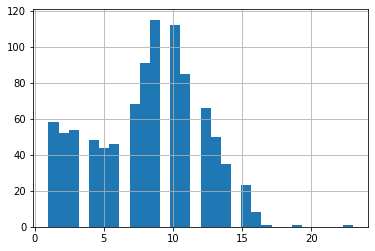

In [ ]:
seq_len = [len(i.split()) for i in df.text]

print(max(seq_len))

pd.Series(seq_len).hist(bins = 30)

### Dataset class

In [ ]:
class myDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])


## Define model structure

Example #3
[Source](https://www.analyticsvidhya.com/blog/2020/07/transfer-learning-for-nlp-fine-tuning-bert-for-text-classification/?)

In [ ]:
from transformers import AutoModel
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert = AutoModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Freeze parameters 
This will prevent updating of model weights during fine-tuning. If you wish to fine-tune even the pre-trained weights of the BERT model then you should not execute the code above.

In [ ]:
for param in bert.parameters():
    param.requires_grad = False

### Define architecture

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model_2 = BERT_Arch(bert)

# push the model to GPU
model_2 = model_2.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model_2.parameters(),lr = 1e-5)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
# define the loss function
cross_entropy  = nn.NLLLoss() 

# number of training epochs
epochs = 10

In [ ]:
# calculate metrics
def metrics(true,output):
  
  accuracy = accuracy_score(y_true=true, y_pred=output)
  recall = recall_score(y_true=true, y_pred=output)
  precision = precision_score(y_true=true, y_pred=output)
  f1 = f1_score(y_true=true, y_pred=output)
  metrics = {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

  return metrics


## Model modes

### Train mode

In [ ]:
# function to train the model
def train_epoch():
  
  model_2.train()

  total_loss= 0  
  # empty list to save model predictions
  total_preds=[]

  
  
  # iterate over batches
  for step,batch in enumerate(train_loader):
    
    # push the batch to gpu
    sent_id = torch.tensor(batch['input_ids']).to(device)
    mask = torch.tensor(batch['attention_mask']).to(device)
    labels = batch['labels'].type(torch.LongTensor).to(device)
    
    # clear previously calculated gradients     
    optimizer.zero_grad()
    
    # get model predictions for the current batch
    preds = model_2(sent_id, mask)

    # compute the loss between actual and predicted values
    ## get avg loss on that batch
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model_2.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    ## shape of preds:(size of batch, 2)
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_loader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

### Eval mode

In [ ]:
# function for evaluating the model
def evaluate_epoch():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model_2.eval()

  total_loss =0  
  # empty list to save the model predictions
  total_preds = []

  # #Early stop
  # early_stopping = EarlyStopping(patience=2, verbose=True)

  # iterate over batches
  for step,batch in enumerate(val_loader):
    
    # push the batch to gpu
    sent_id = torch.tensor(batch['input_ids']).to(device)
    mask = torch.tensor(batch['attention_mask']).to(device)
    labels = batch['labels'].type(torch.LongTensor).to(device)

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model_2(sent_id, mask)
      
      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)  ##avg loss of this batch
      total_loss = total_loss + loss.item()
   
      # get predicted labels for the current batch
      preds=preds.detach().cpu().numpy()
      pred_labels = np.argmax(preds, axis=1)
      total_preds.append(pred_labels)
      

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_loader) 
 

  # reshape the predictions in form of (number of samples)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

## Prepare train/val dataset at each fold

In [ ]:
def prepare_folddata(trainid, valid):
  
  # Split into train & validation
  train = train_data_aug.iloc[trainid] #df
  val = train_data_aug.iloc[valid]  #df

  # Prepare for x: tokenize text
  ## train dataset
  train_text = list(train.text.astype('str'))
  x_train = tokenizer(train_text,padding=True, truncation=True, max_length=15)

  ## val dataset
  val_text = list(val.text.astype('str'))
  x_val = tokenizer(val_text,padding=True, truncation=True, max_length=15)

  # Prepare for y
  y_train = list(train.labels) 
  y_val = list(val.labels) 

  return x_train, y_train, x_val, y_val 


# Fine-tuning 

### Generate data to balance class data

In [ ]:
# Generate data by augmenter
# augmenter = aug_transformers_sub (substitute words by Bert model)
train_data_aug = generate_data(aug_transformers_sub)

In [ ]:
train_data_aug.labels.value_counts()

1.0    810
0.0    727
Name: labels, dtype: int64

In [ ]:
# 5-fold Cross validation
from sklearn.model_selection import KFold

splits = KFold(n_splits=5,shuffle=True,random_state=300)

### Train

In [ ]:
history = {'fold':[],'epoch':[],'train_loss': [], 'valid_loss': [],
              'accuracy':[],'f1':[],'precision':[], 'recall':[]}


for fold, (train_idx,val_idx) in enumerate(splits.split(train_data_aug)):

    print('Fold {}'.format(fold + 1))
    x_train, y_train, x_val, y_val = prepare_folddata(train_idx,val_idx)
    
    # Create Dataset objects as Trainer's inputs
    train_dataset = myDataset(x_train, y_train)
    val_dataset = myDataset(x_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

    # set initial loss to infinite
    best_valid_loss = float('inf')

    # empty lists to store training and validation loss of each epoch
    train_losses=[]
    valid_losses=[]

    
    #for each epoch
    for epoch in range(epochs):
        
        print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
        
        #train model
        train_loss, _ = train_epoch()
        
        #evaluate model
        valid_loss, valid_labels = evaluate_epoch()

        
        #save the best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model_2.state_dict(), 'saved_weights.pt')
        
        
        # append training and validation loss
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        # append validation metrics
        val_metrics = metrics(y_val, valid_labels)
        

        history['fold'].append((fold+1))
        history['epoch'].append((epoch+1))
        history['train_loss'].append(train_loss)
        history['valid_loss'].append(valid_loss)
        history['accuracy'].append(val_metrics['accuracy'])
        history['f1'].append(val_metrics['f1'])
        history['precision'].append(val_metrics['precision'])
        history['recall'].append(val_metrics['recall'])


        print(f'\nTraining Loss: {train_loss:.3f}')
        print(f'Validation Loss: {valid_loss:.3f}')
  # return history

Fold 1

 Epoch 1 / 10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Evaluating...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


### Evaluation: Model Performance

In [ ]:
from google.colab import files
files.download('saved_weights.pt') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
Fold_summary = pd.DataFrame(history)
Fold_summary

,fold,epoch,train_loss,valid_loss,accuracy,f1,precision,recall
0,1,1,0.686107,0.663606,0.571429,0.698630,0.564576,0.916168
1,1,2,0.680430,0.657342,0.564935,0.700893,0.558719,0.940120
2,1,3,0.670113,0.649216,0.571429,0.693023,0.566540,0.892216
3,1,4,0.669777,0.644367,0.594156,0.704492,0.582031,0.892216
4,1,5,0.663301,0.638448,0.616883,0.714976,0.599190,0.886228
5,1,6,0.658149,0.634546,0.626623,0.721550,0.605691,0.892216
6,1,7,0.656996,0.628849,0.652597,0.726343,0.633929,0.850299
7,1,8,0.647800,0.622853,0.642857,0.736842,0.613546,0.922156
8,1,9,0.643896,0.617387,0.646104,0.736077,0.617886,0.910180
9,1,10,0.638469,0.616093,0.740260,0.774011,0.732620,0.820359


In [ ]:
Fold_summary.loc[Fold_summary.epoch==epochs]

,fold,epoch,train_loss,valid_loss,accuracy,f1,precision,recall
1,1,2,0.674249,0.609991,0.833333,0.238095,0.416667,0.166667
3,2,2,0.661121,0.612838,0.760417,0.178571,0.192308,0.166667
5,3,2,0.658808,0.582146,0.859375,0.425532,0.588235,0.333333
7,4,2,0.646795,0.547476,0.853403,0.300000,0.600000,0.200000
9,5,2,0.645296,0.564369,0.858639,0.490566,0.565217,0.433333


In [ ]:
hyper_history = dict()

In [ ]:
hyper_history['word2vec'] = Fold_summary

# Evaluate on Test set

In [ ]:
test_data.labels.value_counts()

0.0    81
1.0    15
Name: labels, dtype: int64

In [ ]:
test_text = list(test_data.text.astype('str'))
test_token = tokenizer(test_text,padding=True, truncation=True, max_length=15)

In [ ]:
test_dataset = myDataset(test_token,test_data.labels)
test_loader = DataLoader(test_dataset, batch_size=16,shuffle=False)

In [ ]:
path = 'saved_weights_w2v.pt'
model_2.load_state_dict(torch.load(path))

In [ ]:
test_labels=[]
for step,batch in enumerate(test_loader):
  
  # push the batch to gpu
  sent_id = torch.tensor(batch['input_ids']).to(device)
  mask = torch.tensor(batch['attention_mask']).to(device)

  # deactivate autograd
  with torch.no_grad():
    
    # model predictions
    preds = model_2(sent_id, mask)

    # get predicted labels for the current batch
    pred_labels = np.argmax(preds.detach().cpu().numpy(), axis=1)
    test_labels.append(pred_labels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [ ]:
metrics(test_data.labels,test_labels)

# Label data

## Load unlabeled data

In [ ]:
c = pd.read_csv('charliehebdo-target-df.csv', encoding = 'utf-8', header = 0)

In [ ]:
unlabel_data = c.loc[~c.reply_tweet_id.isin(list(reply.reply_tweet_id)),['cleaned_reply_tw']]
unlabel_data.columns=['text']

In [ ]:
unlabel_data.shape

(6287, 1)

In [ ]:
unlabel_text = list(unlabel_data.text.astype('str'))
unlabel_token = tokenizer(unlabel_text,padding=True, truncation=True, max_length=15)

In [ ]:
unlabel_dataset = myDataset(unlabel_token)
unlabel_loader = DataLoader(unlabel_dataset, batch_size=16)

## Load model

In [ ]:
path = 'saved_weights.pt'
model_2.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
unlabel_labels=[]
for step,batch in enumerate(unlabel_loader):
  
  # push the batch to gpu
  sent_id = torch.tensor(batch['input_ids']).to(device)
  mask = torch.tensor(batch['attention_mask']).to(device)

  # deactivate autograd
  with torch.no_grad():
    
    # model predictions
    preds = model_2(sent_id, mask)

    # get predicted labels for the current batch
    pred_labels = np.argmax(preds.detach().cpu().numpy(), axis=1)
    unlabel_labels.append(pred_labels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


(array([0, 1]), array([4363, 1924]))

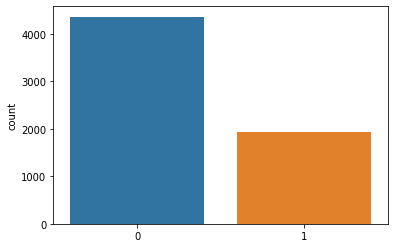

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

unlabel_labels = np.concatenate(unlabel_labels,axis=0)
sns.countplot(x=unlabel_labels)
np.unique(unlabel_labels, return_counts=True)